### Extrapolate using most plausible models discovered.

In this notebook, we look at all the models with reasonable extrapolation characteristics in one place, having tuned any relevant hyper-parameters in individual notebooks.

A prediction dataset (built separately) is load for used with each model.

We fit and test each model, reporting $R^2$ and RMSE, then plot the model with the data to view goodness of fit.  Each model is then used to forecast cost/watt for 2017 and 2018 using the prediction dataset.

All predictions are then combined on a single graph for comparison.

A combination of all predictions (mean) is constructed, graphed and chosen as the upper bound of the prediction.  This combined prediction has the both the stability of lower-bias models and goodness of fit associated with the higher bias (and more accurate) models  Model 6 is chosen as the lower bound.  The shapes of upper and lower bounds are well matched.

* model01: OLS linear model, one feature, time (days) of cost vs. time (days) for baseline. $R^2$: 0.4090, RMSE: 1.6461


* model02: OLS linear model, three features, time(days), size_kw, state.  $R^2$: 0.4667, RMSE: 1.5638


* model03: find best OLS (polynomial) model for three features, time, size_kw, state. Requires excluding one-hot encoded state from polynomial expansion. Best poly degree: 14, $R^2$: R^2: 0.5319, RMSE: 1.4651.

    See https://github.com/leonkato/springboard/blob/master/solar-cap-1/model/model_04.ipynb for model construction and tuning.



* model04: random forest: Best parameters: RFRmax_depth: 15, RFRn_estimators: 20. Best R squared: 0.596, 1.3490
    See https://github.com/leonkato/springboard/blob/master/solar-cap-1/model/model_04.ipynb for model construction and tuning.



* model05: OLS model median of cost as linear function of one variables, time (weeks).  R^2: 0.7013, RMSE: 0.9868
 

* model06: OLS model median of cost as (polynomial) function of one variables, time.   Most reasonable extrapolation for 6-8 quarters of the low bias models.

    See https://github.com/leonkato/springboard/blob/master/solar-cap-1/model/model_median_01 for model construction and tuning.


* model07: OLS model median of cost as (polynomial) function of two variables, time (months) and size. Size is grouped into 2.5kw wide bins.  Best poly_degree: 8;  R^2: 0.8512, RMSE: 0.7236.

    See https://github.com/leonkato/springboard/blob/master/solar-cap-1/model/model_median_02 for model construction and tuning.


* model08: OLS model median of cost as (polynomial) function of two variables, time (weeks) and size. Size is grouped into 2.5kw wide bins.  Best poly_degree: 8; R^2: 0.8386, RMSE: 0.7559

    See https://github.com/leonkato/springboard/blob/master/solar-cap-1/model/model_median_02 for model construction and tuning.

In [1]:
# setup
import datetime

%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 8))
np.set_printoptions(precision=4, suppress=False)
# please show all columns
pd.set_option("display.max_columns", 60)
import seaborn as sns
sns.set()

# Import sklearn stuff

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline,  make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor

In [2]:
# load up
dfMod = pd.read_csv('../local/data/LBNL_openpv_tts_data/model_data_2.csv',
                    index_col='row_id',
                    parse_dates=['install_date'])

In [3]:
# look at some rows
dfMod.sample(n=3).head()

,num_days,num_weeks,num_months,size_kw,scaleSize,state,cost_per_watt,install_date
row_id,,,,,,,,
186278,5080.0,726.0,167.0,4.32,1.0,CA,5.589352,2011-12-07
21485,3043.0,435.0,100.0,8.40,3.0,CA,6.862857,2006-05-10
831750,6586.0,941.0,216.0,8.58,3.0,CA,3.403263,2016-01-21


In [4]:
dfMod.install_date.iloc[0], dfMod.install_date.iloc[-1]

(Timestamp('1998-01-09 00:00:00'), Timestamp('2016-12-31 00:00:00'))

#### Data begins 1998-01-09 and ends 2016-12-31; 19 years

In [5]:
19*365

6935

#### Ranges of the time variables

In [6]:
print(dfMod.iloc[-1, :][['num_days', 'num_weeks', 'num_months']])

num_days      6931
num_weeks      990
num_months     227
Name: 1094908, dtype: object


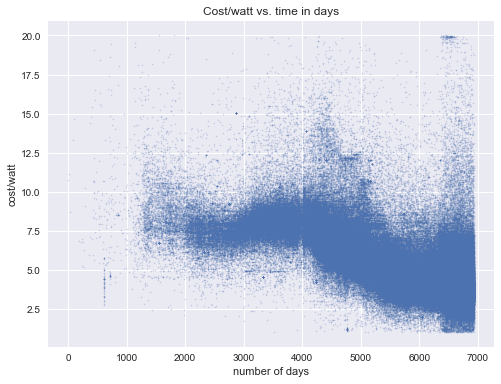

In [7]:
# plot the data
fig, ax = plt.subplots(figsize=(8, 6))
sTitle = 'Cost/watt vs. time in days'

ax.set_title(sTitle)
ax.scatter(dfMod.num_days, dfMod.cost_per_watt,
               marker='.', s=6, alpha=0.2)
ax.set_ylabel('cost/watt')
ax.set_xlabel('number of days')
plt.show();

#### One-hot encode state and shuffle data (remove time ordering, for train_test_split).

In [8]:
dfMod = pd.get_dummies(dfMod.sample(frac=1.0), drop_first=True); dfMod.head(3)

,num_days,num_weeks,num_months,size_kw,scaleSize,cost_per_watt,install_date,state_AZ,state_CA,state_CT,state_DE,state_FL,state_MA,state_MD,state_MN,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OR,state_PA,state_TX,state_VT,state_WI
row_id,,,,,,,,,,,,,,,,,,,,,,,,,
1077162,6905.0,987.0,227.0,5.88,2.0,4.000000,2016-12-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1046067,6859.0,980.0,225.0,10.89,4.0,2.820937,2016-10-20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
14229,2656.0,380.0,87.0,2.40,0.0,5.671667,2005-04-18,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
dfMod.columns

Index(['num_days', 'num_weeks', 'num_months', 'size_kw', 'scaleSize',
       'cost_per_watt', 'install_date', 'state_AZ', 'state_CA', 'state_CT',
       'state_DE', 'state_FL', 'state_MA', 'state_MD', 'state_MN', 'state_NH',
       'state_NJ', 'state_NM', 'state_NV', 'state_NY', 'state_OR', 'state_PA',
       'state_TX', 'state_VT', 'state_WI'],
      dtype='object')

#### load prediction data

In [10]:
predData = pd.read_csv('mod_pred_data.csv', index_col=0)

In [11]:
predData.columns

Index(['num_days', 'num_weeks', 'num_months', 'size_kw', 'scaleSize',
       'state_AZ', 'state_CA', 'state_CT', 'state_DE', 'state_FL', 'state_MA',
       'state_MD', 'state_MN', 'state_NH', 'state_NJ', 'state_NM', 'state_NV',
       'state_NY', 'state_OR', 'state_PA', 'state_TX', 'state_VT', 'state_WI'],
      dtype='object')

---
---

---
## OLS regression with linear model of cost vs. time (days) for baseline (mod01)
---

In [12]:
# features: num_days
X = dfMod[['num_days']]
y = dfMod[['cost_per_watt']]

R^2: 0.4003
RMSE: 1.6639


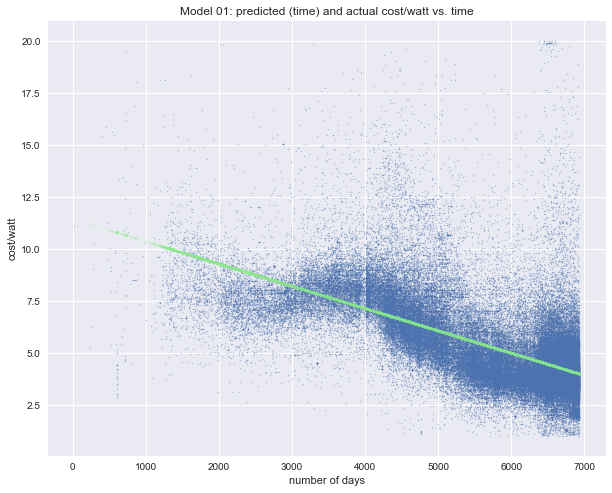

In [13]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=42)
# Instantiate the regressor
linReg = LinearRegression()
# Train the model
linReg.fit(X_train, y_train)
# Predict on the test set
yhat = linReg.predict(X_test)
# Compute and print R^2 and RMSE
print("R^2: {:.4f}".format(linReg.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, yhat))
print("RMSE: {:.4f}".format(rmse))

# plot prediction and actual
fig, ax = plt.subplots(figsize=(10, 8))
sTitle = 'Model 01: predicted (time) and actual cost/watt vs. time'
ax.set_title(sTitle)
ax.scatter(X_test.num_days, y_test, marker='.', s=5, alpha=0.3,)
ax.scatter(X_test.num_days, linReg.predict(X_test), s=4, alpha=0.1, color='lightgreen')
ax.set_ylabel('cost/watt')
ax.set_xlabel('number of days')
plt.show();

In [14]:
print(linReg.coef_, linReg.intercept_)

[[-0.0011]] [11.4382]


#### predict on data including time extrapolation

In [15]:
# we only need the first group beacuse it's time only
theX=predData[['num_days']][:84]

In [16]:
theY = linReg.predict(theX)

### Extrapolate 2017 and 2018

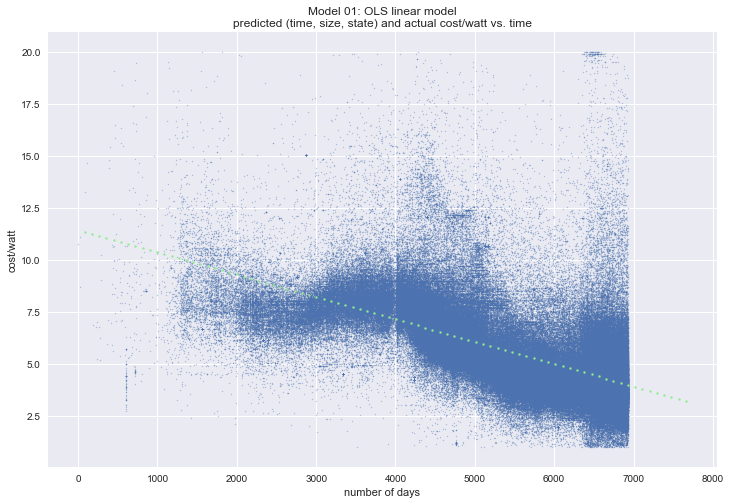

In [17]:
# plot prediction and actual
fig, ax = plt.subplots(figsize=(12, 8))
sTitle = 'Model 01: OLS linear model\npredicted (time, size, state) and actual cost/watt vs. time'
ax.set_title(sTitle)
# actual
ax.scatter(X.num_days, y, marker='.', s=5, alpha=0.3,)
# predicted
ax.scatter(theX.num_days, theY, s=4, alpha=1.0, color='lightgreen')
ax.set_ylabel('cost/watt')
ax.set_xlabel('number of days')
plt.show();

In [18]:
mod01X = theX
mod01Y = theY

---
## OLS regression with linear model of time (days), size and state for baseline (mod02)
---

In [19]:
# features: state, num_days and size_kw 
X = dfMod.drop(['num_weeks', 'num_months', 'scaleSize', 'cost_per_watt', 'install_date'], axis='columns')
y = dfMod[['cost_per_watt']]

R^2: 0.4594
RMSE: 1.5797


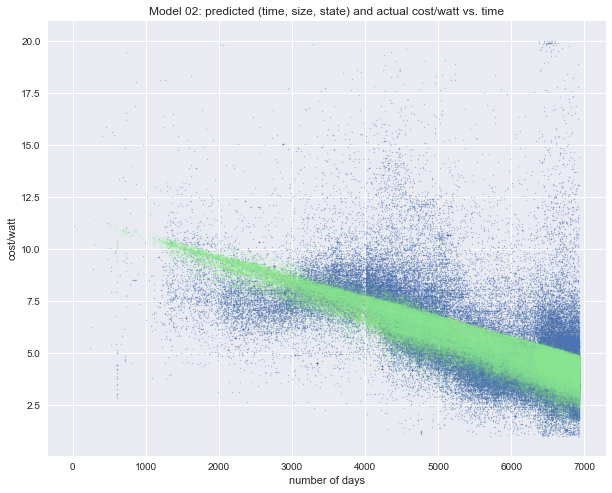

In [20]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=42)
# Instantiate the regressor
linReg = LinearRegression()
# Train the model
linReg.fit(X_train, y_train)
# Predict on the test set
yhat = linReg.predict(X_test)
# Compute and print R^2 and RMSE
print("R^2: {:.4f}".format(linReg.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, yhat))
print("RMSE: {:.4f}".format(rmse))

# plot prediction and actual
fig, ax = plt.subplots(figsize=(10, 8))
sTitle = 'Model 02: predicted (time, size, state) and actual cost/watt vs. time'
ax.set_title(sTitle)
ax.scatter(X_test.num_days, y_test, marker='.', s=5, alpha=0.3,)
ax.scatter(X_test.num_days, linReg.predict(X_test), s=4, alpha=0.1, color='lightgreen')
ax.set_ylabel('cost/watt')
ax.set_xlabel('number of days')
plt.show();

In [21]:
print(linReg.coef_, linReg.intercept_)

[[-9.9312e-04 -1.2858e-01 -9.7161e-01 -1.8903e-01 -5.8044e-01 -3.2537e-01
  -4.3954e-02 -2.8088e-01 -1.2095e-01  3.4156e-01 -9.6673e-01  5.2834e-01
  -5.0801e-01 -8.5015e-01 -3.3332e-01 -5.0729e-01 -2.1446e-01 -1.0990e+00
  -9.2469e-01 -5.3348e-01]] [12.0875]


#### predict on data including time extrapolation

In [22]:
theX=predData.drop(['num_weeks', 'num_months', 'scaleSize'], axis='columns')

In [23]:
theY = linReg.predict(theX)

### Extrapolate 2017 and 2018

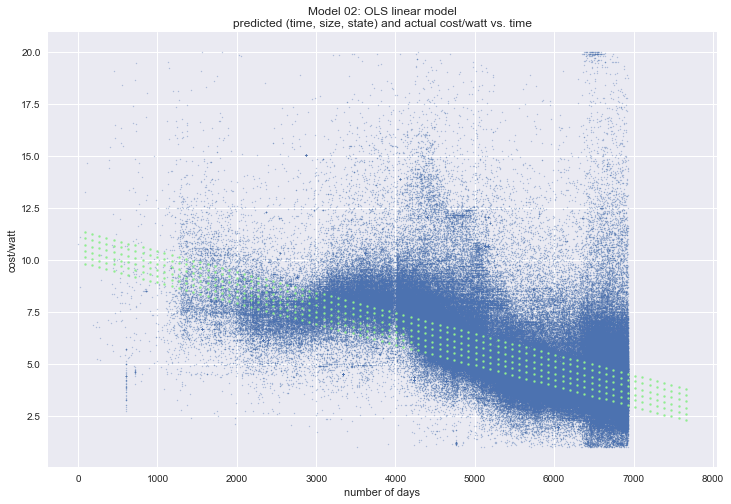

In [24]:
# plot prediction and actual
fig, ax = plt.subplots(figsize=(12, 8))
sTitle = 'Model 02: OLS linear model\npredicted (time, size, state) and actual cost/watt vs. time'
ax.set_title(sTitle)
# actual
ax.scatter(X.num_days, y, marker='.', s=5, alpha=0.3,)
# predicted
ax.scatter(theX.num_days, theY, s=4, alpha=1.0, color='lightgreen')
ax.set_ylabel('cost/watt')
ax.set_xlabel('number of days')
plt.show();

In [25]:
# capture mod02 X and y
# using time, size and state, so that's all the input
# aggregate sizes and states for comparison plot below
dfMod02 = pd.DataFrame()
dfMod02 = dfMod02.assign(mod02x=theX.num_days)
dfMod02 = dfMod02.assign(mod02y=theY.ravel())

mod02agged = dfMod02.groupby(['mod02x']).mean()

In [26]:
mod02agged.head()

,mod02y
mod02x,
81,10.576996
172,10.486622
264,10.395255
356,10.303888
446,10.214507


In [27]:
len(mod02agged)

84

---
---

---
## OLS with best polynomial model, cost ~ time, size, state (mod03)
---

#### Make pipeline to build features

In [28]:
### make it an estimator and a transformer for general use
class ColumnExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_cols = X[self.columns]
        return X_cols

In [29]:
# first, add LR to the pipeline
# take the data apart; numerical vars get scaled, then go to polynomial; state dummies pass through; 
# they get glued back together for the regression.
theStates = ['state_AZ', 'state_CA', 'state_CT', 'state_DE', 'state_FL', 'state_MA',
             'state_MD', 'state_MN', 'state_NH', 'state_NJ', 'state_NM', 'state_NV',
             'state_NY', 'state_OR', 'state_PA', 'state_TX', 'state_VT', 'state_WI']

thePipe = Pipeline([
    ('features', 
     FeatureUnion([('num_vars', 
                    Pipeline([('extract', ColumnExtractor(columns=['num_days', 'size_kw'])),
                              ('scale', StandardScaler()),
                              ('poly', PolynomialFeatures())
                              ])),
                   ('cat_vars',
                    ColumnExtractor(columns=theStates))
                  ]) # end of FeatureUnion
    ),
    ('LR', LinearRegression())
]) # end of Pipeline

In [30]:
thePipe.get_params().keys()

dict_keys(['memory', 'steps', 'features', 'LR', 'features__n_jobs', 'features__transformer_list', 'features__transformer_weights', 'features__num_vars', 'features__cat_vars', 'features__num_vars__memory', 'features__num_vars__steps', 'features__num_vars__extract', 'features__num_vars__scale', 'features__num_vars__poly', 'features__num_vars__extract__columns', 'features__num_vars__scale__copy', 'features__num_vars__scale__with_mean', 'features__num_vars__scale__with_std', 'features__num_vars__poly__degree', 'features__num_vars__poly__include_bias', 'features__num_vars__poly__interaction_only', 'features__cat_vars__columns', 'LR__copy_X', 'LR__fit_intercept', 'LR__n_jobs', 'LR__normalize'])

In [31]:
# features: state, num_days and size_kw 
X = dfMod.drop(['num_weeks', 'num_months', 'scaleSize', 'cost_per_watt', 'install_date'], axis='columns')
y = dfMod[['cost_per_watt']]

R^2: 0.5250
RMSE: 1.4808


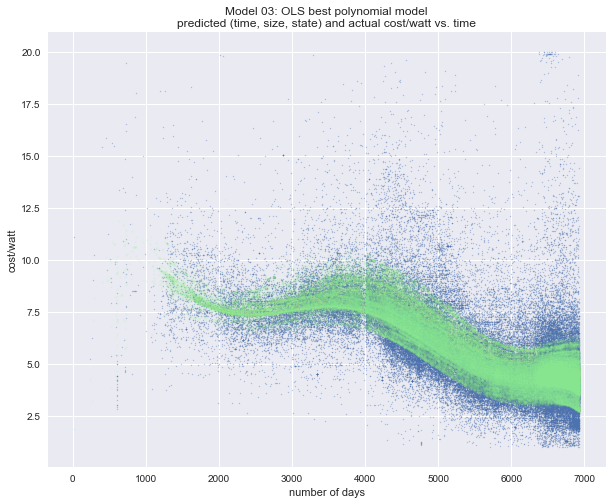

In [32]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=42)
# Instantiate the regressor
olsPoly = thePipe
# the best poly degree from grid search
olsPoly.set_params(features__num_vars__poly__degree=6)
# Train the model
olsPoly.fit(X_train, y_train)
# Predict on the test set
yhat = olsPoly.predict(X_test)
# Compute and print R^2 and RMSE
print("R^2: {:.4f}".format(olsPoly.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, yhat))
print("RMSE: {:.4f}".format(rmse))

# plot prediction and actual
fig, ax = plt.subplots(figsize=(10, 8))
sTitle = 'Model 03: OLS best polynomial model\npredicted (time, size, state) and actual cost/watt vs. time'
ax.set_title(sTitle)
ax.scatter(X_test.num_days, y_test, marker='.', s=5, alpha=0.3,)
ax.scatter(X_test.num_days, olsPoly.predict(X_test), s=4, alpha=0.1, color='lightgreen')
ax.set_ylabel('cost/watt')
ax.set_xlabel('number of days')
plt.show();

#### Extrapolate 2017 and 2018

In [33]:
theX=predData.drop(['num_weeks', 'num_months', 'scaleSize'], axis='columns')

In [34]:
theX.columns

Index(['num_days', 'size_kw', 'state_AZ', 'state_CA', 'state_CT', 'state_DE',
       'state_FL', 'state_MA', 'state_MD', 'state_MN', 'state_NH', 'state_NJ',
       'state_NM', 'state_NV', 'state_NY', 'state_OR', 'state_PA', 'state_TX',
       'state_VT', 'state_WI'],
      dtype='object')

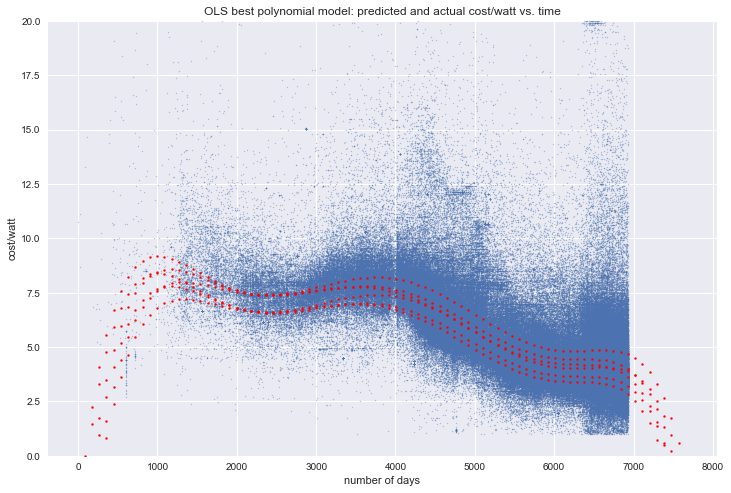

In [35]:
theY = olsPoly.predict(theX)

# plot prediction and actual
fig, ax = plt.subplots(figsize=(12, 8))
sTitle = 'OLS best polynomial model: predicted and actual cost/watt vs. time'
ax.set_title(sTitle)
# actual
ax.scatter(X.num_days, y, marker='.', s=5, alpha=0.3,)
# predicted
ax.scatter(theX.num_days, theY, s=4, alpha=1.0, color='red')
ax.set_ylabel('cost/watt')
ax.set_xlabel('number of days')
ax.set_ylim(0,20)
plt.show();

In [36]:
# capture mod03 X and y
mod03X, mod3Y = theX, theY

In [37]:
# capture mod02 X and y
# using time, size and state, so that's all the input
# aggregate sizes and states for comparison plot below
dfMod03 = pd.DataFrame()
dfMod03 = dfMod03.assign(mod03x=theX.num_days)
dfMod03 = dfMod03.assign(mod03y=theY.ravel())

mod03agged = dfMod03.groupby(['mod03x']).mean()

In [38]:
mod03agged.head()

,mod03y
mod03x,
81,-3.156752
172,-0.647404
264,1.450975
356,3.163161
446,4.512734


### Yes, this one has strange predictions early and late...

In [39]:
dfMod03[dfMod03.mod03x == 81]

,mod03x,mod03y
0,81,0.007104
84,81,-2.926763
168,81,-5.357122
252,81,-0.788546
336,81,-3.722413
420,81,-6.152773


---
---

---
## Random Forest Regressor with best parameters (mod04)

In [40]:
# features: state, num_days and size_kw 
X = dfMod.drop(['num_weeks', 'num_months', 'scaleSize', 'cost_per_watt', 'install_date'], axis='columns')
y = dfMod[['cost_per_watt']]

In [41]:
X.columns

Index(['num_days', 'size_kw', 'state_AZ', 'state_CA', 'state_CT', 'state_DE',
       'state_FL', 'state_MA', 'state_MD', 'state_MN', 'state_NH', 'state_NJ',
       'state_NM', 'state_NV', 'state_NY', 'state_OR', 'state_PA', 'state_TX',
       'state_VT', 'state_WI'],
      dtype='object')

C:\Users\saus\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


R^2: 0.5963
RMSE: 1.3657


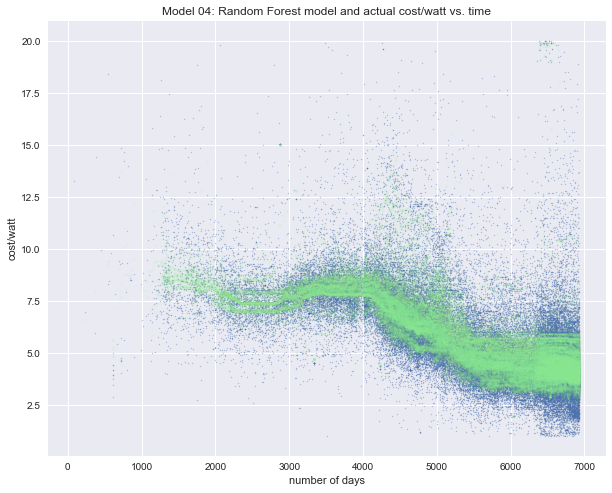

In [42]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=21)
# Instantiate the regressor
rfr = RandomForestRegressor()
# set best parameters
rfr.set_params(n_estimators=20, max_depth=15)
# Train the model
rfr.fit(X_train, y_train)
# Predict on the test set
yhat = rfr.predict(X_test)
# Compute and print R^2 and RMSE
print("R^2: {:.4f}".format(rfr.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, yhat))
print("RMSE: {:.4f}".format(rmse))

# plot prediction and actual
fig, ax = plt.subplots(figsize=(10, 8))
sTitle = 'Model 04: Random Forest model and actual cost/watt vs. time'
ax.set_title(sTitle)
ax.scatter(X_test.num_days, y_test, marker='.', s=5, alpha=0.3,)
ax.scatter(X_test.num_days, rfr.predict(X_test), s=4, alpha=0.1, color='lightgreen')
ax.set_ylabel('cost/watt')
ax.set_xlabel('number of days')
plt.show();

#### predict on data including time extrapolation, 3 sizes and 2 states

In [43]:
theX=predData.drop(['num_weeks', 'num_months', 'scaleSize'], axis='columns')

In [44]:
theY = rfr.predict(theX)

###  Extrapolate RFR for 2017 and 2018

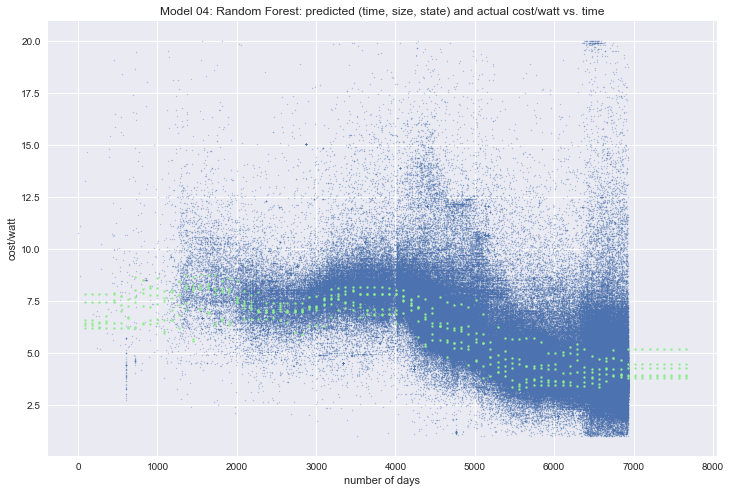

In [45]:
# plot prediction and actual
fig, ax = plt.subplots(figsize=(12, 8))
sTitle = 'Model 04: Random Forest: predicted (time, size, state) and actual cost/watt vs. time'
ax.set_title(sTitle)
# actual
ax.scatter(X.num_days, y, marker='.', s=5, alpha=0.3,)
# predicted
ax.scatter(theX.num_days, theY, s=4, alpha=1.0, color='lightgreen')
ax.set_ylabel('cost/watt')
ax.set_xlabel('number of days')
plt.show();

In [46]:
# capture mod04 X and y
mod04X, mod04Y = theX, theY

In [47]:
# capture mod02 X and y
# using time, size and state, so that's all the input
# aggregate sizes and states for comparison plot below
dfMod04 = pd.DataFrame()
dfMod04 = dfMod04.assign(mod04x=mod04X.num_days)
dfMod04 = dfMod04.assign(mod04y=mod04Y.ravel())

mod04agged = dfMod04.groupby(['mod04x']).mean()

In [48]:
mod04agged.head()

,mod04y
mod04x,
81,6.787078
172,6.787078
264,6.761342
356,6.864582
446,7.208324


---
---

---

## OLS linear model of median cost/watt (1 feature, time in weeks) ((mod05))

---

In [49]:
# get the median cost/watt by week
by_week = dfMod.groupby(['num_weeks'])
median_week = by_week.cost_per_watt.median()

In [50]:
median_week.head()

num_weeks
0.0     10.734315
3.0     11.108701
4.0      8.667013
12.0    13.270286
16.0    14.654839
Name: cost_per_watt, dtype: float64

In [51]:
# make a poly expansion of median (8th degree)
medW = Pipeline([('scale', StandardScaler()), 
                       ('poly', PolynomialFeatures()),
                       ('LR', LinearRegression())
                    ])

In [52]:
medW.set_params(poly__degree=1)

Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('poly', PolynomialFeatures(degree=1, include_bias=True, interaction_only=False)), ('LR', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [53]:
# transform time (num_weeks) to create X
X = median_week.index.values.reshape(-1, 1)
y = median_week.values.reshape(-1, 1)

In [54]:
# Create training and test sets and hand it the scaled and poly-expanded data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=21)

In [55]:
# Train the model
medW.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('poly', PolynomialFeatures(degree=1, include_bias=True, interaction_only=False)), ('LR', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [56]:
# Predict on the test set
yhat = medW.predict(X_test)
# Compute and print R^2 and RMSE
print("R^2: {:.4f}".format(medW.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, yhat))
print("RMSE: {:.4f}".format(rmse))

R^2: 0.7013
RMSE: 0.9868


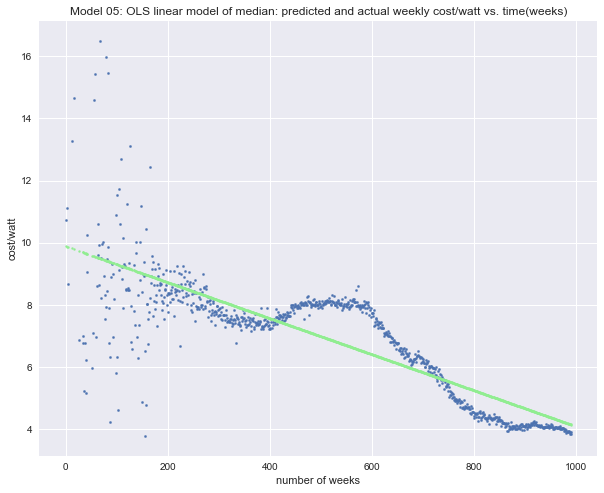

In [57]:
# plot prediction and actual
fig, ax = plt.subplots(figsize=(10, 8))
sTitle = 'Model 05: OLS linear model of median: predicted and actual weekly cost/watt vs. time(weeks)'
ax.set_title(sTitle)

# actual
ax.scatter(X, y, marker='o', s=5, alpha=1,)
# predicted
ax.scatter(X, medW.predict(X), s=4, alpha=1, color='lightgreen')
ax.set_ylabel('cost/watt')
ax.set_xlabel('number of weeks')
plt.show();

### Extrapolate 2017 and 2018

In [58]:
### we want the weeks from the prediction data; ignore everything else for this model
pred_data_weeks = predData[:84][['num_weeks']]

In [59]:
theX = pred_data_weeks.values # a series
theY = medW.predict(theX.reshape(-1, 1))

C:\Users\saus\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


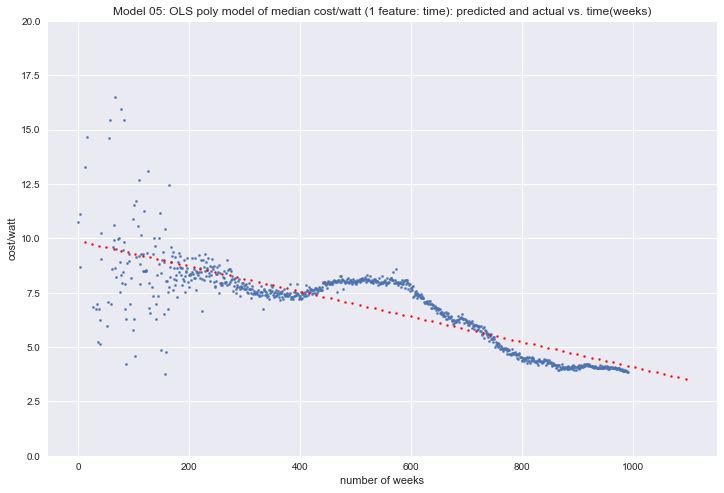

In [60]:
# plot prediction and actual
fig, ax = plt.subplots(figsize=(12, 8))
sTitle = 'Model 05: OLS poly model of median cost/watt (1 feature: time): predicted and actual vs. time(weeks)'
ax.set_title(sTitle)
# actual
ax.scatter(X, y, marker='o', s=5, alpha=1)
# predicted
ax.scatter(theX, theY, s=4, alpha=1.0, marker='o', color='red')
ax.set_ylabel('cost/watt')
ax.set_xlabel('number of weeks')
ax.set_ylim(0, 20)
plt.show;

In [61]:
# capture mod04 X and y. Y values are all ready to go into dfTheModels
mod05X, mod05Y = theX, theY

---

---

---

## OLS polynomial model of median cost/watt (1 feature, time in weeks) ((mod06))

---

In [62]:
# get the median cost/watt by week
by_week = dfMod.groupby(['num_weeks'])
median_week = by_week.cost_per_watt.median()

In [63]:
median_week.head()

num_weeks
0.0     10.734315
3.0     11.108701
4.0      8.667013
12.0    13.270286
16.0    14.654839
Name: cost_per_watt, dtype: float64

In [64]:
# make a poly expansion of median (8th degree)
medW = Pipeline([('scale', StandardScaler()), 
                       ('poly', PolynomialFeatures()),
                       ('LR', LinearRegression())
                    ])

In [65]:
medW.set_params(poly__degree=8)

Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('poly', PolynomialFeatures(degree=8, include_bias=True, interaction_only=False)), ('LR', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [66]:
# transform time (num_weeks) to create X
X = median_week.index.values.reshape(-1, 1)
y = median_week.values.reshape(-1, 1)

In [67]:
# Create training and test sets and hand it the scaled and poly-expanded data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=21)

In [68]:
# Train the model
medW.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('poly', PolynomialFeatures(degree=8, include_bias=True, interaction_only=False)), ('LR', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [69]:
# Predict on the test set
yhat = medW.predict(X_test)
# Compute and print R^2 and RMSE
print("R^2: {:.4f}".format(medW.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, yhat))
print("RMSE: {:.4f}".format(rmse))

R^2: 0.8341
RMSE: 0.7355


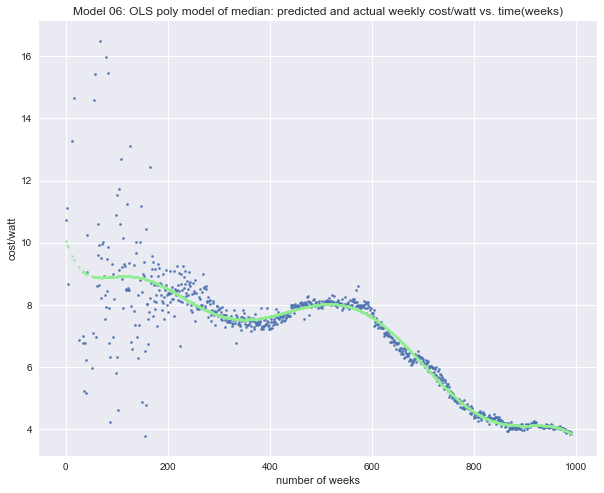

In [70]:
# plot prediction and actual
fig, ax = plt.subplots(figsize=(10, 8))
sTitle = 'Model 06: OLS poly model of median: predicted and actual weekly cost/watt vs. time(weeks)'
ax.set_title(sTitle)

# actual
ax.scatter(X, y, marker='o', s=5, alpha=1,)
# predicted
ax.scatter(X, medW.predict(X), s=4, alpha=1, color='lightgreen')
ax.set_ylabel('cost/watt')
ax.set_xlabel('number of weeks')
plt.show();

### Extrapolate 2017 and 2018

In [71]:
### we want the weeks from the prediction data; ignore everything else for this model
pred_data_weeks = predData[:84][['num_weeks']]

In [72]:
theX = pred_data_weeks.values # a series
theY = medW.predict(theX.reshape(-1, 1))

C:\Users\saus\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


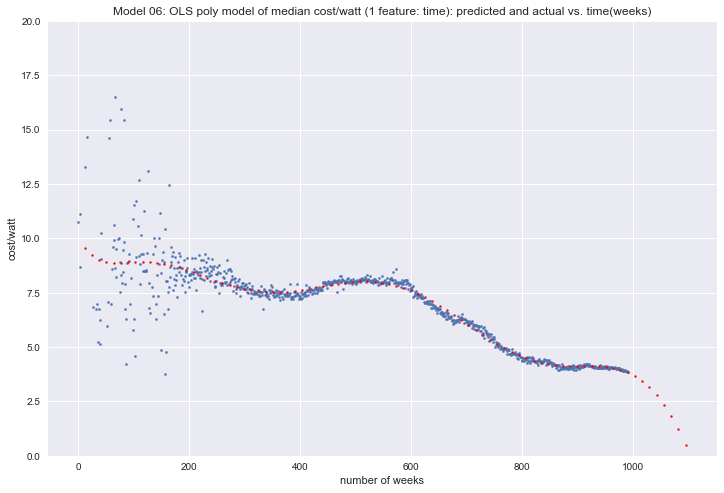

In [73]:
# plot prediction and actual
fig, ax = plt.subplots(figsize=(12, 8))
sTitle = 'Model 06: OLS poly model of median cost/watt (1 feature: time): predicted and actual vs. time(weeks)'
ax.set_title(sTitle)
# actual
ax.scatter(X, y, marker='o', s=5, alpha=1)
# predicted
ax.scatter(theX, theY, s=4, alpha=1.0, marker='o', color='red')
ax.set_ylabel('cost/watt')
ax.set_xlabel('number of weeks')
ax.set_ylim(0, 20)
plt.show;

In [74]:
# capture mod06 X and y.  These Y values are the right shape for dfTheModels.
mod06X, mod06Y = theX, theY

---

---

---
### OLS Polynomial of median cost/watt (2 features, time in months, size group) ((mod07))

---

In [75]:
# get the median by month and size
by_month_size = dfMod.groupby(['num_months', 'scaleSize'])
med_by_month_size = by_month_size.cost_per_watt.median()
# use a df to make accessing features easier
dfMedByMonthSize = pd.DataFrame(med_by_month_size).reset_index(); dfMedByMonthSize.head()

,num_months,scaleSize,cost_per_watt
0,0.0,0.0,10.921508
1,1.0,0.0,8.667013
2,3.0,0.0,13.962563
3,6.0,1.0,6.858942
4,7.0,0.0,6.768190


In [76]:
# make a poly expansion of median (8th degree) with scaling and LR
medMS = Pipeline([('scale', StandardScaler()),
                         ('poly', PolynomialFeatures()),
                         ('LR', LinearRegression())])

medMS.set_params(poly__degree=8)

Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('poly', PolynomialFeatures(degree=8, include_bias=True, interaction_only=False)), ('LR', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [77]:
### Yes, looking at the real data grouped by month and scale size, agg'ed by median
X = dfMedByMonthSize[['num_months', 'scaleSize']]
y = dfMedByMonthSize[['cost_per_watt']].values
X.shape, y.shape

((1778, 2), (1778, 1))

In [78]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=21)

# Train the model
medMS.fit(X_train, y_train)
# Predict on the test set
yhat = medMS.predict(X_test)
# Compute and print R^2 and RMSE
print("R^2: {:.4f}".format(medMS.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, yhat))
print("RMSE: {:.4f}".format(rmse))

R^2: 0.8512
RMSE: 0.7236


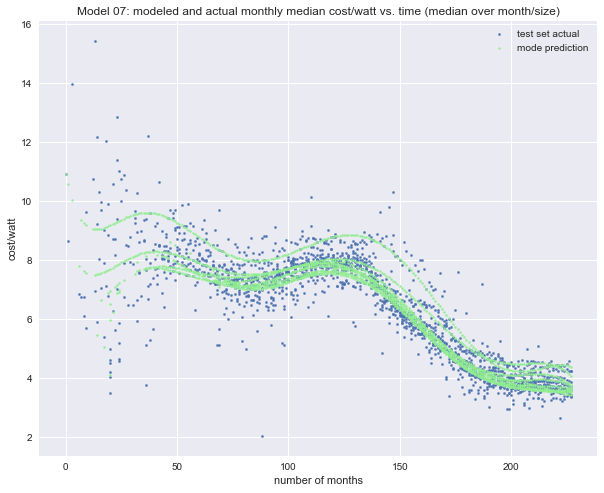

In [79]:
# plot prediction and actual
fig, ax = plt.subplots(figsize=(10, 8))
sTitle = 'Model 07: modeled and actual monthly median cost/watt vs. time (median over month/size)'
ax.set_title(sTitle)
# actual
ax.scatter(X.num_months, y, marker='o', s=5, alpha=1, label='test set actual')
ax.scatter(X.num_months, medMS.predict(X), s=4, alpha=1, color='lightgreen', label='mode prediction')
ax.set_ylabel('cost/watt')
ax.set_xlabel('number of months')
ax.legend()
plt.show();

#### predict on data including time extrapolation and 3 most common size groups

### Extrapolate 2017 and 2018

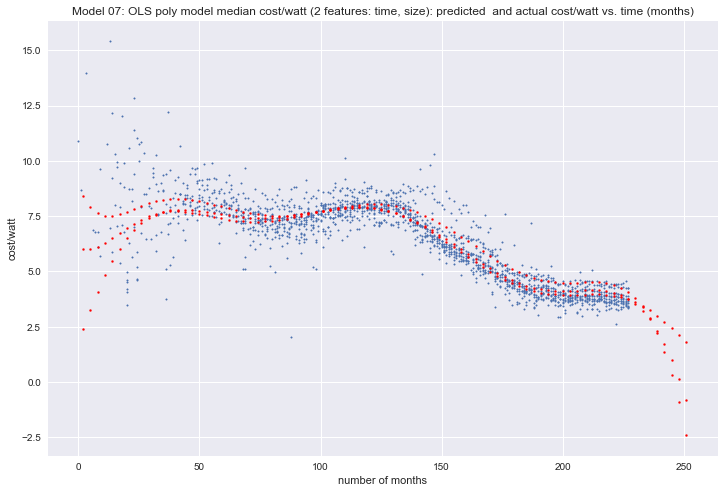

In [80]:
# grab month and size 
# (only need the first half because we're ignoring state)
theX = predData[['num_months', 'scaleSize']][:252]

# poly8.fit_transform(theX.values.reshape(-1, 1))
theY = medMS.predict(theX.values)

# plot prediction and actual
fig, ax = plt.subplots(figsize=(12, 8))
sTitle = 'Model 07: OLS poly model median cost/watt (2 features: time, size): predicted  and actual cost/watt vs. time (months)'
ax.set_title(sTitle)
# actual
ax.scatter(X.num_months, y, marker='.', s=10, alpha=1.0)

# predicted
ax.scatter(theX.num_months, theY, s=4, alpha=1.0, marker='o', color='red')
ax.set_ylabel('cost/watt')
ax.set_xlabel('number of months')
#ax.set_ylim(-10, 20)
plt.show;

In [81]:
# capture mod07 X and y
# using time, size; that's 252 rows
# aggregate sizes and states for comparison plot below
dfMod07 = pd.DataFrame()
dfMod07 = dfMod07.assign(mod07x=theX.num_months)
dfMod07 = dfMod07.assign(mod07y=theY.ravel())
mod07agged = dfMod07.groupby(['mod07x']).mean()

---
---

---
### OLS Polynomial of median cost/watt (2 features: time in weeks, size group) ((mod08))

---

In [82]:
# get the median by week and size
by_week_size = dfMod.groupby(['num_weeks', 'scaleSize'])
med_by_week_size = by_week_size.cost_per_watt.median()
# use a df to make accessing features easier
dfMedByWeekSize = pd.DataFrame(med_by_week_size).reset_index(); dfMedByWeekSize.head()

,num_weeks,scaleSize,cost_per_watt
0,0.0,0.0,10.734315
1,3.0,0.0,11.108701
2,4.0,0.0,8.667013
3,12.0,0.0,13.270286
4,16.0,0.0,14.654839


In [83]:
# make a poly expansion of median (8th degree) with scaling and LR
medWS = Pipeline([('scale', StandardScaler()),
                  ('poly', PolynomialFeatures()),
                  ('LR', LinearRegression())])

medWS.set_params(poly__degree=8)

Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('poly', PolynomialFeatures(degree=8, include_bias=True, interaction_only=False)), ('LR', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [84]:
### Yes, looking at the real data grouped by week and scale size, agg'ed by median
X = dfMedByWeekSize[['num_weeks', 'scaleSize']]
y = dfMedByWeekSize[['cost_per_watt']].values
X.shape, y.shape

((6598, 2), (6598, 1))

In [85]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=21)

# Train the model
medWS.fit(X_train, y_train)
# Predict on the test set
yhat = medWS.predict(X_test)
# Compute and print R^2 and RMSE
print("R^2: {:.4f}".format(medWS.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, yhat))
print("RMSE: {:.4f}".format(rmse))

R^2: 0.8386
RMSE: 0.7559


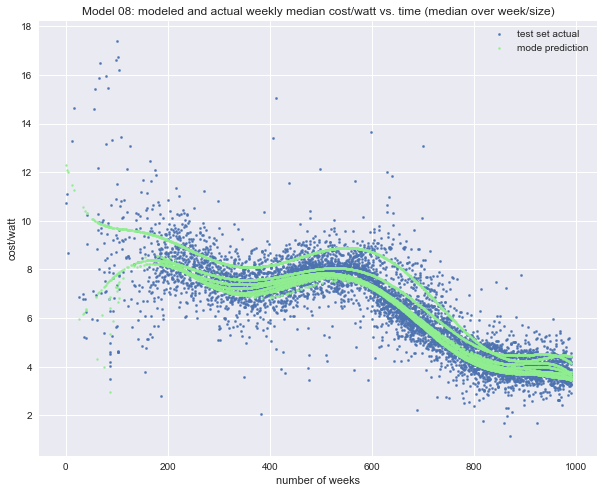

In [86]:
# plot prediction and actual
fig, ax = plt.subplots(figsize=(10, 8))
sTitle = 'Model 08: modeled and actual weekly median cost/watt vs. time (median over week/size)'
ax.set_title(sTitle)
# actual
ax.scatter(X.num_weeks, y, marker='o', s=5, alpha=1, label='test set actual')
# predicted
ax.scatter(X.num_weeks, medWS.predict(X), s=4, alpha=1, color='lightgreen', label='mode prediction')
ax.set_ylabel('cost/watt')
ax.set_xlabel('number of weeks')
ax.legend()
plt.show();

#### predict on data including time extrapolation and 3 most common size groups

### Extrapolate 2017 and 2018

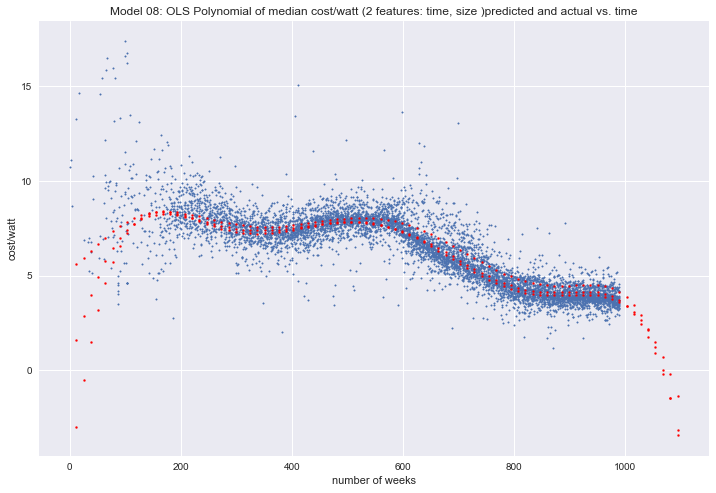

In [87]:
# grab week and size 
# (only need the first half because we're ignoring state)
theX = predData[['num_weeks', 'scaleSize']][:252]

# poly8.fit_transform(theX.values.reshape(-1, 1))
theY = medWS.predict(theX.values)

# plot prediction and actual
fig, ax = plt.subplots(figsize=(12, 8))
sTitle = 'Model 08: OLS Polynomial of median cost/watt (2 features: time, size )predicted and actual vs. time'
ax.set_title(sTitle)
# actual
ax.scatter(X.num_weeks, y, marker='.', s=10, alpha=1.0)

# predicted
ax.scatter(theX.num_weeks, theY, s=4, alpha=1.0, marker='o', color='red')
ax.set_ylabel('cost/watt')
ax.set_xlabel('number of weeks')
#ax.set_ylim(-10, 20)
plt.show;

In [88]:
# capture mod08 X and y
# using time, size; that's 252 rows
# aggregate sizes and states for comparison plot below
dfMod08 = pd.DataFrame()
dfMod08 = dfMod08.assign(mod08x=theX.num_weeks)
dfMod08 = dfMod08.assign(mod08y=theY.ravel())
mod08agged = dfMod08.groupby(['mod08x']).mean()

---
---

### Put them all on the same chart

Here's the strategy: I plotted every prediction above.  When I do those plots, I can capture the plotted values in a variable (maybe df).  After having grabbed them all, I can plot at once.

They're all grabbed.  Now get the time base for each and whether it needs aggregation

* mod01: OLS linear   days
* mod02: days - needs agg
* mod03: days - needs agg
* mod04: days - needs agg
* mod05: weeks
* mod06: weeks
* mod07: months - needs agg
* mod08: weeks - needs agg

__make a df for all the models, time is in days for all.  y's for each model are aggregated if necessary; one column for each model's (aggregated) y.__

In [89]:
dfTheModels = pd.DataFrame()

__*mod01*__

In [90]:
dfTheModels = dfTheModels.assign(mod01x=mod01X.values.ravel())

In [91]:
dfTheModels = dfTheModels.assign(mod01=mod01Y.ravel())

__*mod02*__

In [92]:
dfTheModels = dfTheModels.assign(mod02=mod02agged.mod02y.values)

__*mod03*__

In [93]:
dfTheModels = dfTheModels.assign(mod03=mod03agged.mod03y.values)

__*mod04*__

In [94]:
dfTheModels = dfTheModels.assign(mod04=mod04agged.mod04y.values)

__*mod05*__

In [95]:
dfTheModels = dfTheModels.assign(mod05=mod05Y)

__*mod06*__

In [96]:
dfTheModels = dfTheModels.assign(mod06=mod06Y)

__*mod07*__

In [97]:
dfTheModels = dfTheModels.assign(mod07=mod07agged.mod07y.values)

__*mod08*__

In [98]:
dfTheModels = dfTheModels.assign(mod08=mod08agged.mod08y.values)

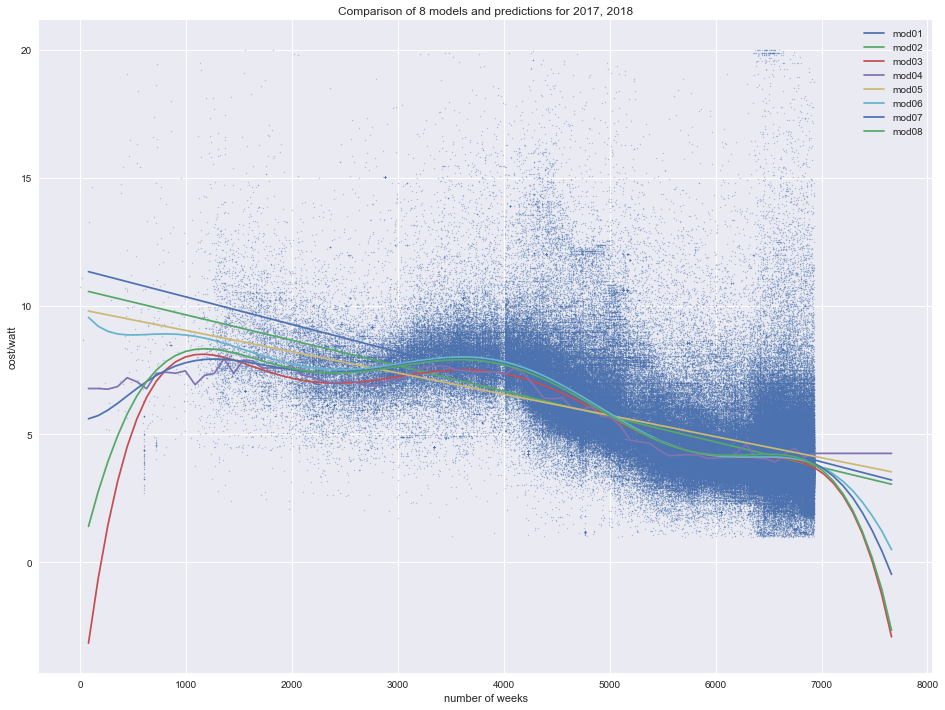

In [99]:
fig, ax = plt.subplots(figsize=(16,12))

ax.scatter(dfMod.num_days, dfMod.cost_per_watt, marker='.', s=5, alpha=0.3)

dfTheModels.drop(['mod01x'], axis='columns').plot(x=dfTheModels.mod01x, ax=ax)

ax.set_title('Comparison of 8 models and predictions for 2017, 2018');
ax.set_xlabel('number of weeks')
ax.set_ylabel('cost/watt');

In [100]:
pd.set_option('precision', 2)

In [101]:
pred1215_1217 = dfTheModels[-9:]; pred1215_1217

,mod01x,mod01,mod02,mod03,mod04,mod05,mod06,mod07,mod08
75,6931,4.00,3.77,3.70,4.25,4.14,3.85,3.87,3.82
76,7021,3.90,3.68,3.45,4.25,4.06,3.68,3.65,3.55
77,7112,3.80,3.59,3.09,4.25,3.99,3.45,3.36,3.17
78,7204,3.70,3.50,2.60,4.25,3.91,3.16,2.99,2.67
79,7296,3.61,3.41,1.94,4.25,3.84,2.79,2.51,2.02
80,7386,3.51,3.32,1.12,4.25,3.76,2.35,1.94,1.20
81,7477,3.41,3.23,0.06,4.25,3.69,1.83,1.25,0.19
82,7569,3.31,3.14,-1.27,4.25,3.61,1.22,0.45,-1.05
83,7661,3.21,3.05,-2.91,4.25,3.53,0.49,-0.47,-2.65


In [102]:
pred1215_1217[['mod06']].values.T

array([[3.8462, 3.6776, 3.4506, 3.1574, 2.7917, 2.3487, 1.8263, 1.2249,
        0.494 ]])

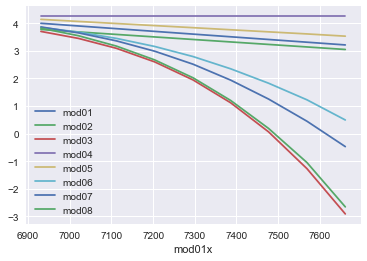

In [103]:
pred1215_1217.drop('mod01x', axis='columns').plot(x=pred1215_1217.mod01x);

In [104]:
pd.set_option('precision',2)

In [105]:
mean_predict = pred1215_1217.drop('mod01x', axis='columns').mean(axis='columns')

In [106]:
mean_predict

75    3.92
76    3.78
77    3.59
78    3.35
79    3.05
80    2.68
81    2.24
82    1.71
83    1.06
dtype: float64

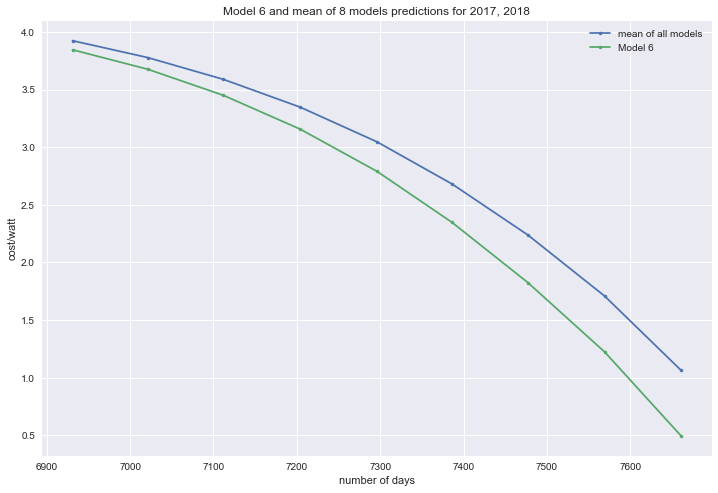

In [107]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(pred1215_1217.mod01x, mean_predict, label='mean of all models',  marker='.')
ax.plot(pred1215_1217.mod01x, pred1215_1217.mod06, label='Model 6', marker='.')
ax.set_title('Model 6 and mean of 8 models predictions for 2017, 2018');
ax.set_xlabel('number of days')
ax.set_ylabel('cost/watt')
ax.legend();